本节我们以一个动态渲染网站<https://dynamic1.scrape.cuiqingcai.com/> 为例来试验一下Ajax的爬取。  
这个页面看似和我们上一课时的案例一模一样，但其实不是，它的后台实现逻辑和数据加载方式与上一课时完全不同，只不过最后呈现的样式是一样的。  
本节我们需要完成的目标有：  
1.分析页面数据的加载逻辑。  
2.用requests实现Ajax数据的爬取。  
3.将每部电影的数据保存成一个JSON数据文件。  

In [8]:
import requests
import logging
from requests.packages import urllib3
urllib3.disable_warnings() # 忽略证书警告

In [7]:
url = 'https://dynamic1.scrape.cuiqingcai.com'
html = requests.get(url,verify=False).text
print(html)
'''可以看到直接抓取的话，只加载了原来网页html代码的一点点
并没有看到有关电影数据的任何信息
说明我们现在看到的整个页面是通过JavaScript渲染得到的''';

<!DOCTYPE html><html lang=en><head><meta charset=utf-8><meta http-equiv=X-UA-Compatible content="IE=edge"><meta name=viewport content="width=device-width,initial-scale=1"><link rel=icon href=/favicon.ico><title>Scrape | Movie</title><link href=/css/chunk-700f70e1.1126d090.css rel=prefetch><link href=/css/chunk-d1db5eda.0ff76b36.css rel=prefetch><link href=/js/chunk-700f70e1.0548e2b4.js rel=prefetch><link href=/js/chunk-d1db5eda.b564504d.js rel=prefetch><link href=/css/app.ea9d802a.css rel=preload as=style><link href=/js/app.17b3aaa5.js rel=preload as=script><link href=/js/chunk-vendors.683ca77c.js rel=preload as=script><link href=/css/app.ea9d802a.css rel=stylesheet></head><body><noscript><strong>We're sorry but portal doesn't work properly without JavaScript enabled. Please enable it to continue.</strong></noscript><div id=app></div><script src=/js/chunk-vendors.683ca77c.js></script><script src=/js/app.17b3aaa5.js></script></body></html>


可以通过直接爬取Ajax接口获取数据
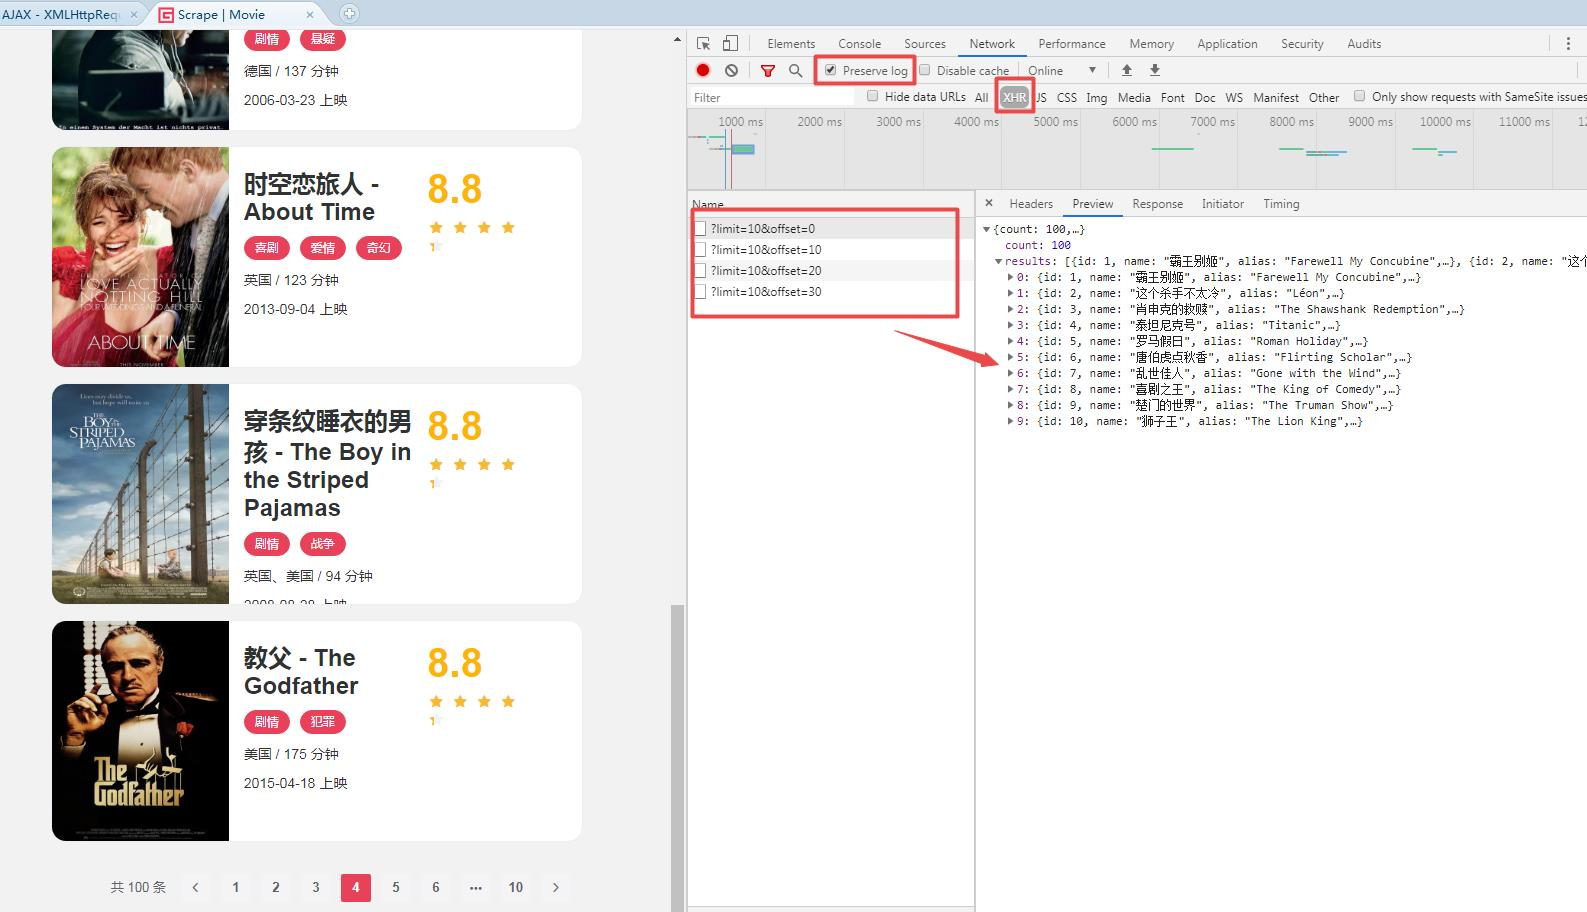

1. 定义日志输出级别和输出格式

In [9]:
logging.basicConfig(level=logging.INFO, # 输出级别
                   format='%(asctime)s-%(levelname)s:%(message)s') # 输出格式

2. 定义根URL

In [24]:
# {} {} 留到后面用format传入值
INDEX_URL = 'https://dynamic1.scrape.cuiqingcai.com/api/movie/?limit={}&offset={}'

In [12]:
INDEX_URL

'https://dynamic1.scrape.cuiqingcai.com/api/movie/?limit=&offset='

3. 定义函数：接收一个url参数，返回页面的html.text代码。

In [14]:
def scrape_api(url):
    logging.info(f'正在爬取{url}……')
    try:
        response = requests.get(url, verify=False)
    except requests.RequestException:
        logging.error('爬取%s时发生了一个错误', url, exc_info=True)
        # 这时，将logging.error的exc_info参数设置为True可以打印出Traceback错误信息。
    else:
        if response.status_code == 200:
            return response.json()
        else:
            logging.error(f'爬取{url}失败，错误代码{response.status_code}。')

4. 定义函数：接收一个page页码参数，返回页面该页面Ajax请求得到的html代码。

In [29]:
limit = 10
def scrape_index(page):
    url = INDEX_URL.format(limit,(page-1)*limit)
    return scrape_api(url)

5. 定义函数：收参数id，返回该id的电影详情Ajax请求页的代码

In [32]:
DETAIL_URL = 'https://dynamic1.scrape.cuiqingcai.com/api/movie/{}'
def scrape_detail(id):
    url = DETAIL_URL.format(id)
    return scrape_api(url)

In [33]:
scrape_detail(1)

2021-10-11 19:31:35,687-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/1……


{'id': 1,
 'name': '霸王别姬',
 'alias': 'Farewell My Concubine',
 'cover': 'https://p0.meituan.net/movie/ce4da3e03e655b5b88ed31b5cd7896cf62472.jpg@464w_644h_1e_1c',
 'categories': ['剧情', '爱情'],
 'regions': ['中国内地', '中国香港'],
 'actors': [{'name': '张国荣',
   'role': '程蝶衣',
   'image': 'https://p0.meituan.net/movie/5de69a492dcbd3f4b014503d4e95d46c28837.jpg@128w_170h_1e_1c'},
  {'name': '张丰毅',
   'role': '段小楼',
   'image': 'https://p0.meituan.net/movie/35e74707f69da838d7ba3422b8f6579840705.jpg@128w_170h_1e_1c'},
  {'name': '巩俐',
   'role': '菊仙',
   'image': 'https://p1.meituan.net/moviemachine/b650dcb00c40356934a275515217850f191104.jpg@128w_170h_1e_1c'},
  {'name': '吕齐',
   'role': '关师傅',
   'image': 'https://p1.meituan.net/movie/30e12a78b5e61916edb1e33ce6fec19b34794.jpg@128w_170h_1e_1c'},
  {'name': '英达',
   'role': '戏园老板',
   'image': 'https://p0.meituan.net/movie/cdedec80554d04a6139dc5270f5e7b5b35118.jpg@128w_170h_1e_1c'},
  {'name': '葛优',
   'role': '袁四爷',
   'image': 'https://p1.meituan.ne

6. 定义函数以json格式保存文件

In [43]:
import json
from os import makedirs
from os.path import exists
RESULTS_DIR = 'results' # 命名一个叫results的文件夹
exists(RESULTS_DIR) or makedirs(RESULTS_DIR) # 有就跳过；没有就新建results文件夹
def save_data(data):
    name = data.get('name') # 取得 传入数据的name字段
    data_path = f'{RESULTS_DIR}/{name}.json' # 拼接存储路径
    # dump方法保存json文件
    json.dump(data, open(data_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

7. 调用函数&爬取数据

In [44]:
TOTAL_PAGE = 10
for page in range(1, TOTAL_PAGE+1):
    page_data = scrape_index(page)
    page_data = page_data.get('results')
    for i in page_data:
        id = i.get('id')
        detail_data = scrape_detail(id)
        save_data(detail_data)
        

2021-10-11 19:50:49,548-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/?limit=10&offset=0……
2021-10-11 19:50:50,048-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/1……
2021-10-11 19:50:50,535-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/2……
2021-10-11 19:50:50,802-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/3……
2021-10-11 19:50:51,203-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/4……
2021-10-11 19:50:51,540-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/5……
2021-10-11 19:50:51,848-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/6……
2021-10-11 19:50:52,295-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/7……
2021-10-11 19:50:52,743-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/8……
2021-10-11 19:50:53,400-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/9……
2021-10-11 19:50:53,995-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/10……
2021-10-11 19:50:54,307-INFO:正在爬取htt

2021-10-11 19:51:31,107-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/85……
2021-10-11 19:51:31,407-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/86……
2021-10-11 19:51:31,799-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/87……
2021-10-11 19:51:32,448-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/88……
2021-10-11 19:51:32,886-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/89……
2021-10-11 19:51:33,638-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/90……
2021-10-11 19:51:34,104-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/?limit=10&offset=90……
2021-10-11 19:51:34,547-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/91……
2021-10-11 19:51:34,998-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/92……
2021-10-11 19:51:35,295-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/93……
2021-10-11 19:51:35,641-INFO:正在爬取https://dynamic1.scrape.cuiqingcai.com/api/movie/94……
2021-10-11 19:51:36,193-IN